In [1]:
### RUN EVERY TIME: COMTRADE DATASETS EXTRACTING

In [2]:
### RUN EVERY TIME: INITIALIZATION

import pandas as pd
import numpy as np
import gc
import os
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [3]:
### RUN EVERY TIME: VERSION CONTROL

from platform import python_version
print('python version: ', python_version())
print('numpy version: ', np.__version__)
print('pandas version: ', pd.__version__)

python version:  3.7.4
numpy version:  1.17.2
pandas version:  0.25.3


In [4]:
### RUN EVERY TIME: MAIN CONSTANTS

### MultiIndex level slice constant:
All = slice(None)
### Universe path:
str_path_universe = 'Data_Files/Source_Files/acadian_universe.xlsx'
### Dates:
str_date_end = '2022-12-31'
date_start = pd.Timestamp('1989-12-29')
date_end = pd.Timestamp(str_date_end)
date_ison = pd.Timestamp('1994-12-31')
### NA for MS Excel files:
list_na_excel_values = ['', '#N/A', '#N/A N/A', '#NA', '-1.#IND', '-1.#QNAN', '-NaN', '-nan', '1.#IND', '1.#QNAN', 'N/A', 'NULL', 'NaN', 'n/a', 'nan', 'null',
                        '#N/A Requesting Data...', '#N/A Invalid Security', '#N/A Field Not Applicable', '---']
### Checked EBOPS service IDs list (df_serv_to_gics['GICS Group Code']):
list_services = ['206', '210', '214', '218', '219', '223', '227', '231', '232', '237', '240', '246', '247', '250', '251', '254', '255', '256', '257', '258', '263',
                 '264', '269', '272', '273', '288', '289', '292', '293', '294', '310', '391', '431', '500', '888', '891', '892', '894', '950']
### Augmented bilateral export:
str_path_export_bilateral = 'Data_Files/Source_Files/comtrade_export_bilateral.h5'
### Export key:
str_key_unc_export = 'export_augmented'
### Export Quality Index:
str_path_imf_quality_detailed = 'Data_Files/Source_Files/imf_export_quality_detailed.h5'
str_path_imf_quality = 'Data_Files/Source_Files/imf_export_quality.h5'
### Export key:
str_key_imf_eq = 'export_quality'
### Trade Value Index:
str_path_imf_trade_detailed = 'Data_Files/Source_Files/imf_trade_value_detailed.h5'
str_path_imf_trade = 'Data_Files/Source_Files/imf_trade_value.h5'
### Export key:
str_key_imf_trade = 'trade_value'
### HS to SITC Conversion Map:
str_path_commodity_map_xlsx = 'Data_Files/Source_Files/hs_to_sitc.xlsx'
str_page_map = 'HS to SITC'
### Factor file:
str_path_quality_exp = 'Data_Files/Source_Files/comtrade_quality_detailed.h5'
str_key_comtrade_factor = 'comtrade_factor'
str_path_factor_xlsx = 'Data_Files/Source_Files/comtrade_factor.xlsx'
str_path_factor_csv = 'Data_Files/Source_Files/comtrade_factor.csv'

In [5]:
### DEFINING WEIGHTED AVERAGE CALCULATOR

def weighted_average(ser_data, ser_weight = None, int_min_count = 0):
    ### Default output:
    num_result = np.NaN
    ### Checking for data presence:
    if (ser_data.count() > int_min_count):       
        ### Checking for weights dataset:
        if ser_weight is None:
            ### Calculating of simple average:
            num_result = np.nanmean(ser_data.values)
        else:
            ### Weights filtering:
            list_weight = ser_weight[ser_data.dropna().index].values
            ### Checking for weights presence:
            if np.nansum(list_weight):
                ### Data filtering:
                list_data = ser_data.dropna().values
                ### Weighted average calculating:
                num_result = np.nansum(list_data * list_weight) / np.nansum(list_weight)
    ### Results output:
    return num_result

In [6]:
### DEFINING EXTRACTION UNIVERSE DATA FROM MS EXCEL SOURCE (TO BE IGNORED IN PRODUCT CODE)

def ison_membership_converting(str_path_universe, date_end, bool_daily = False, int_backfill_months = 0):
    ### Defining business-month-end reindexation on country level:
    def country_modify(ser_raw_country, date_end):
        ser_res_country = ser_raw_country.droplevel(0).resample('MS').last().resample('BM').last()
        range_country = pd.date_range(ser_res_country.index[0], date_end, freq = 'BM')
        return ser_res_country.reindex(range_country).ffill()
    ### Markets encoding table:
    dict_markets = {50 : 'DM', 57 : 'EM', 504 : 'FM', 0: np.NaN}     
    ### Loading source file:
    df_raw_universe = pd.read_excel(engine = 'openpyxl', io = str_path_universe, sheet_name = 'Switchers', header = 0, parse_dates = True, index_col = [0, 1],
                                 na_values = list_na_excel_values, keep_default_na = False)
    ### Converting source file:
    df_raw_universe.index.names = ['Country', 'Date']
    ser_raw_universe = df_raw_universe['Region']
    ser_raw_universe.fillna(0, inplace = True)
    ser_raw_universe.name = 'Market'
    ### By country reindexation and translation:
    ser_res_universe = ser_raw_universe.groupby('Country').apply(country_modify, date_end)
    ser_res_universe.index.names = ['Country', 'Date']
    ser_res_universe = ser_res_universe.replace(dict_markets).reorder_levels([1, 0]).sort_index() 
    ### Expanding membership for primary regions members by backfilling:
    if int_backfill_months:
        ### List of regions:
        list_region = list(ser_res_universe.dropna().unique())
        ### Initialising of collection of series with backfilled data for each region:
        list_ison_backfill = []
        ### Regions looping:
        for iter_region in list_region:
            ### Defining start of region date:
            date_first_valid = ser_res_universe.loc[ser_res_universe == iter_region].first_valid_index()[0]
            ### Creating dates index to backfilling:
            idx_date_backfill = pd.date_range(end = date_first_valid, periods = int_backfill_months + 1, freq = 'BM')[: -1]
            ### Creating primary countries index to backfilling:            
            idx_region_backfill = ser_res_universe.loc[ser_res_universe == iter_region].loc[date_first_valid, All].index.get_level_values('Country')
            ### Creating full index:
            idx_ison_backfill = pd.MultiIndex.from_product([idx_date_backfill, idx_region_backfill])
            ### Series with backfilled data:
            list_ison_backfill.append(pd.Series(iter_region, index = idx_ison_backfill))
        ### Combination of backfilled series and original ISON data:    
        ser_res_universe = ser_res_universe.combine_first(pd.concat(list_ison_backfill, axis = 0)).sort_index()  
        ser_res_universe.index.names = ['Date', 'Country']
    ### Converting to daily frequency:
    if bool_daily:
        ser_res_universe = ser_res_universe.reset_index('Country').groupby('Country').resample('B').ffill()['Market'].swaplevel().sort_index()    
    ### Results output:
    ser_res_universe.name = 'Market'
    return ser_res_universe

In [7]:
### RUN EVERY TIME: COMMON DATA EXTRACTION STEPS

### ISON membership history:
ser_ison_membership = ison_membership_converting(str_path_universe, pd.to_datetime(str_date_end))
ser_ison_membership.index.names = ['Date', 'Country']
### ISON Members:
list_ison_countries = sorted(ser_ison_membership.index.get_level_values('Country').unique())
### ISON status for the last available date:
ser_ison_status = ser_ison_membership.loc[ser_ison_membership.index[-1][0]]

In [8]:
### BILATERAL EXPORT DATA LOADING TO PERFORM FACTOR CALCULATION

gc.collect()
list_export_chunks = []
for num_iter_number, ser_iter_chunk in enumerate(pd.read_hdf(str_path_export_bilateral, key = str_key_unc_export, chunksize = 1000000)):
    gc.collect()
    print(num_iter_number, ': Extraction started')
    ser_iter_chunk = ser_iter_chunk[ser_iter_chunk > 0.0].astype('int32')
    df_iter_chunk = ser_iter_chunk.reset_index()
    df_iter_chunk = df_iter_chunk[(df_iter_chunk['Reporter'] != df_iter_chunk['Partner']) & \
                                  ((df_iter_chunk['Type'] == 'Goods') | df_iter_chunk['Commodity_ID'].isin(list_services)) & (df_iter_chunk['Reporter'] != 'World') & \
                                  (df_iter_chunk['Partner'] != 'World')]\
                               .drop('Type', axis = 1)    
    print(num_iter_number, ': Filtering performed')    
    ser_iter_chunk = df_iter_chunk.set_index(['Date', 'Reporter', 'Partner', 'Commodity_ID']).squeeze().sort_index()
    del df_iter_chunk
    gc.collect()
    list_export_chunks.append(ser_iter_chunk)
    print(num_iter_number, ': Chunk added to container')    
ser_bilateral_export = pd.concat(list_export_chunks, axis = 0, sort = False).sort_index()
ser_bilateral_export.name = 'Export'
del list_export_chunks
gc.collect()

0 : Extraction started
0 : Filtering performed
0 : Chunk added to container
1 : Extraction started
1 : Filtering performed
1 : Chunk added to container
2 : Extraction started
2 : Filtering performed
2 : Chunk added to container
3 : Extraction started
3 : Filtering performed
3 : Chunk added to container
4 : Extraction started
4 : Filtering performed
4 : Chunk added to container
5 : Extraction started
5 : Filtering performed
5 : Chunk added to container
6 : Extraction started
6 : Filtering performed
6 : Chunk added to container
7 : Extraction started
7 : Filtering performed
7 : Chunk added to container
8 : Extraction started
8 : Filtering performed
8 : Chunk added to container
9 : Extraction started
9 : Filtering performed
9 : Chunk added to container
10 : Extraction started
10 : Filtering performed
10 : Chunk added to container
11 : Extraction started
11 : Filtering performed
11 : Chunk added to container
12 : Extraction started
12 : Filtering performed
12 : Chunk added to container
13 

76

In [9]:
### REPORTER / COMMODITY BY DATE TOTAL EXPORT

### Export totals:
ser_country_comm_export = ser_bilateral_export.groupby(['Date', 'Reporter', 'Commodity_ID']).sum().dropna()
ser_country_comm_export.name = 'Export'

del ser_bilateral_export
gc.collect()

23

In [10]:
### IMF EXPORT TRADE DATA LOADING

gc.collect()

ser_trade_data = pd.read_hdf(path_or_buf = str_path_imf_trade_detailed, key = str_key_imf_trade).reorder_levels(['Date', 'Country', 'SITC_ID']).sort_index()
#ser_trade_data = ser_trade_data.to_frame().join(ser_ison_status).set_index('Market', append = True).squeeze()
ser_trade_data = ser_trade_data[date_start : ].drop(['mfg', 'BEC1', 'BEC2', 'BEC3', 'SITC'], axis = 0, level = 'SITC_ID') / 1000
ser_trade_data.name = 'Trade_Value'

In [11]:
### IMF EXPORT QUALITY DATA LOADING

gc.collect()
ser_quality_data = pd.read_hdf(path_or_buf = str_path_imf_quality_detailed, key = str_key_imf_eq).reorder_levels(['Date', 'Country', 'SITC_ID']).sort_index()
#ser_quality_data = ser_quality_data.to_frame().join(ser_ison_status).set_index('Market', append = True).squeeze()
ser_quality_data = ser_quality_data.drop('mfg', axis = 0, level = 'SITC_ID')[date_start : ]

In [12]:
### IMF DATA CONNECTION:

gc.collect()

df_quality_sitc = ser_quality_data.to_frame().join(ser_trade_data)
#df_quality_data = ser_quality_data.to_frame().join(ser_ison_status).dropna(subset = ['Market']).set_index('Market', append = True).join(ser_trade_data)

In [14]:
### QUALITY DEMEANING & COMPETITIVENES AGGREGATING TO SITC_ID AG2:

gc.collect()

def conditional_average(df_group):
    if (len(df_group) > 1):
        flo_result = weighted_average(df_group['Quality'], df_group['Trade_Value'])
    else:
        flo_result = df_group['Quality'].values[0]
    return flo_result

df_quality_sitc.index.set_names('SITC_ID_detailed', level = 'SITC_ID', inplace = True)
df_quality_sitc = df_quality_sitc.reset_index('SITC_ID_detailed')
df_quality_sitc['SITC_ID'] = df_quality_sitc['SITC_ID_detailed'].str[: 2]
df_quality_sitc = df_quality_sitc.set_index('SITC_ID', append = True).sort_index()
### Aggregating data to AG2 SITC level:
ser_quality_sitc = df_quality_sitc.groupby(['Date', 'Country', 'SITC_ID']).apply(conditional_average)
ser_quality_sitc.name = 'Quality'
ser_quality_trade = df_quality_sitc.groupby(['Date', 'Country', 'SITC_ID'])['Trade_Value'].sum()
ser_quality_trade.name = 'Trade_Value'
df_quality_data = pd.concat([ser_quality_sitc, ser_quality_trade], axis = 1)

In [17]:
### HS TO SITC CONVERSION MAP LOADING

df_raw_conversion = pd.read_excel(engine = 'openpyxl', io = str_path_commodity_map_xlsx, sheet_name = str_page_map, header = 0, index_col = None,
                                 na_values = list_na_excel_values, keep_default_na = False, dtype = str)
df_comm_conversion = df_raw_conversion.set_index('Commodity ID')[['SITC Correspondent 1', 'SITC Correspondent 2', 'SITC Correspondent 3']]
ser_comm_conversion = df_comm_conversion.stack().droplevel(-1)
ser_comm_conversion.index.names = ['Commodity_ID']
ser_comm_conversion.name = 'SITC_ID'

In [26]:
### CONVERTING FROM SITC CLASSIFICATION TO HS CLASSIFICATION AND ADDING COMTRADE EXPORT FLOWS

gc.collect()

def conditional_average(df_group):
    if (len(df_group) > 1):
        flo_result = weighted_average(df_group['Quality'], df_group['Trade_Value'])
    else:
        flo_result = df_group['Quality'].values[0]
    return flo_result

### Adding mapping table:
df_quality_comtrade = df_quality_data.join(ser_comm_conversion.to_frame().set_index('SITC_ID', append = True)).reset_index('Commodity_ID')\
                                     .dropna(subset = ['Commodity_ID']).set_index(['Commodity_ID'], append = True)\
                                     .reorder_levels(['Date', 'Country', 'Commodity_ID', 'SITC_ID']).sort_index()
### Performoing weighted average for "n -> 1" conversions:
df_quality_comtrade = df_quality_comtrade.groupby(['Date', 'Country', 'Commodity_ID']).apply(conditional_average).to_frame()
df_quality_comtrade.index.set_names('Reporter', level = 'Country', inplace = True)
df_quality_comtrade.columns = ['Quality']
### Adding ComTrade Export flows:
#df_quality_comtrade = df_quality_comtrade.join(ser_country_comm_export.loc[:, ser_ison_status.index, :], how = 'right').dropna(subset = ['Export'])

In [34]:
### GLOBAL COMMODITY QUALITY CALCULATION

### Calculating of Universe Quality:
ser_ison_mean = df_quality_comtrade.groupby(['Date', 'Commodity_ID'])\
                                     .apply(lambda df_group: weighted_average(df_group['Quality'], df_group['Export'] / 1000))\
                                     .groupby('Commodity_ID').ffill()
ser_ison_mean.name = 'Quality_ISON'
### Joining aggregated Quality values to main dataset:
df_quality_comtrade = df_quality_comtrade.join(ser_ison_mean, how = 'left')
### Forwarding aggregated Quality to expand 2014 values till the end of vector:
df_quality_comtrade[['Quality', 'Quality_ISON']] = df_quality_comtrade[['Quality', 'Quality_ISON']].groupby(['Commodity_ID', 'Reporter']).ffill()

In [46]:
### COMTRADE TRADE DATA BASED INDIVIDUAL EXPORT COMPETETIVENESS FACTOR CALCULATION

ser_ison_un_factor = df_quality_comtrade.groupby(['Date', 'Reporter'])\
                                        .apply(lambda df_group: weighted_average(df_group['Quality_ISON'], df_group['Export'] / 1000))
ser_ison_un_factor.name = 'Product_Lvl_W'

<AxesSubplot:xlabel='Date'>

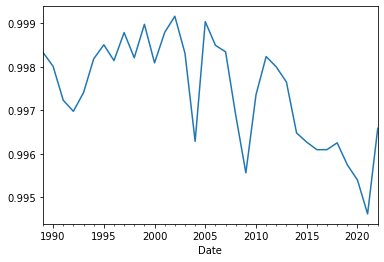

In [50]:
### TEST QUALITY VS DETAILED QUALITY:

ser_quality_simple = pd.read_hdf('Data_Files/Source_Files/comtrade_quality_exp.h5')['Product_Lvl_W']
ser_quality_simple.name = 'Quality_W'

pd.concat([ser_ison_un_factor, ser_quality_simple], axis = 1).groupby('Date').corr().loc[(All, 'Product_Lvl_W'), 'Quality_W'].dropna().droplevel(1).plot()

In [52]:
### COMPETITIVENESS FACTOR RESAMPLING

gc.collect()
### Resampling to monthly data:
def reindex_monthly(ser_group):
    ser_result = ser_group.droplevel(['Reporter']).reindex(pd.date_range(ser_group.index[0][0], str_date_end, freq = 'BY'))
    ser_result = ser_result.resample('BM').ffill()
    return ser_result
ser_factor_monthly = ser_ison_un_factor.groupby('Reporter').apply(reindex_monthly).swaplevel()
ser_factor_monthly.index.names = ['Date', 'Reporter']

In [53]:
### FACTOR SAVING

ser_factor_monthly.to_excel(str_path_factor_xlsx, merge_cells = False)
ser_factor_monthly.to_csv(str_path_factor_csv, sep = ';', header = True)
ser_factor_monthly.to_hdf(str_path_quality_exp, str_key_comtrade_factor)